In [28]:
from pyspark.sql import SparkSession
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline




In [2]:
spark = SparkSession.builder.getOrCreate()
sc = sc = spark.sparkContext

apache_logs = sc.textFile("apache_logs")


In [100]:


def search_result(line):
    regular_expression = r"(?i)\b((?:https?:\/\/|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}\/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    url =re.search(regular_expression, line)
    if url:
        url = url.group(0)
        url = url.replace('//www.','//')
        regular_expression1 = '(?<=\/\/)[^\.]+\.\w+'
        result = re.search(regular_expression1, url)
        if result:
            result = result.group(0)
            return result




lines =apache_logs.map(search_result) 
lines = lines.filter(lambda x: x is not None)
lines = lines.filter(lambda x: x !='semicomplete.com')
lines = lines.map(lambda x: (x,1))
lines = lines.reduceByKey(lambda a, b: a + b)
lines = lines.takeOrdered(10, lambda pair: -pair[1])
lines = pd.DataFrame(lines)
lines


,0,1
0,google.com,909
1,feedparser.org,364
2,search.msn,118
3,FeedBurner.com,108
4,help.yahoo,106
5,yandex.com,86
6,baidu.com,85
7,tt-rss.org,83
8,google.co,77
9,bing.com,63


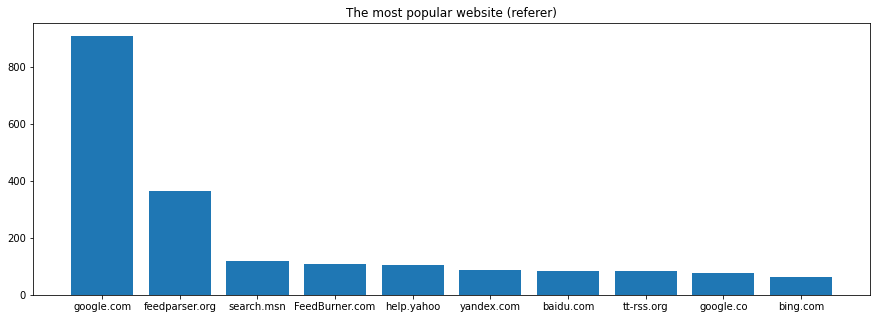

In [104]:
fig = plt.figure(figsize=(15,5))
plt.bar(lines[0],lines[1])
plt.title('The most popular website (referer)')
plt.show()

In [28]:
#\] "(?!GET|HEAD|POST|OPTIONS)

def process(line):
    hour_regex = r"\d{4}:(\d{2}):\d{2}:\d{2}"
    response_regex =r"\"(?:GET|HEAD|POST|OPTIONS)\s[^\"]+\"\s(\d+)"
    hour = int(re.search(hour_regex, line).group(1))
    response = int(re.search(response_regex, line).group(1))
    return ((response, hour),1)
    

    
data = (apache_logs.map(process)
    .reduceByKey(lambda a,b: a+b)
    .sortByKey(ascending=False,keyfunc= lambda x: x)
    .map(lambda x: (x[0][0],x[0][1],x[1]))
    .collect()
)


df = pd.DataFrame(data,columns=['response','hour','amount'])

df


,response,hour,amount
0,500,15,1
1,500,14,1
2,500,3,1
3,416,6,2
4,404,23,4
...,...,...,...
101,200,4,331
102,200,3,338
103,200,2,347
104,200,1,313


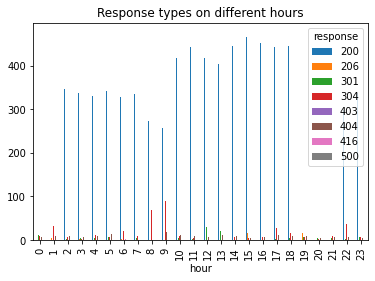

In [29]:
df.pivot("hour", "response", "amount").plot(kind='bar',title='Response types on different hours')
plt.show()


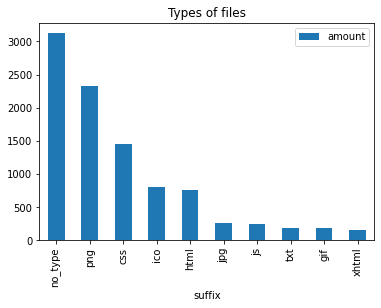

In [36]:

def process(line):
    suffix_regex = r"\"(?:GET|HEAD|POST|OPTIONS)\s[^\"\s]+\.(\w+)(?=\s)"
    ext = re.search(suffix_regex, line)
    if(ext):
        return ext.group(1)

data = (apache_logs.map(process)
    .map(lambda x: 'no_type' if (x is None) else x)
    .map(lambda x: (x,1))
    .reduceByKey(lambda a, b: a + b)
    .takeOrdered(10, lambda pair: -pair[1])
)


df = pd.DataFrame(data,columns=['suffix','amount'])

df.plot(x='suffix',y='amount',kind='bar',title='Types of files')
plt.show()


In [36]:
import ipinfo, pprint
access_token = '487563ad589354'
handler = ipinfo.getHandler(access_token)

regex = '([(\d\.)]+)'
ips = apache_logs.map(lambda s: (re.match(regex, s).group(0)))

results = pprint.pprint(handler.getMap(ips.collect()))



'https://ipinfo.io/tools/map/85802cb8-eccc-4c27-91cf-8af97cf73ca2'


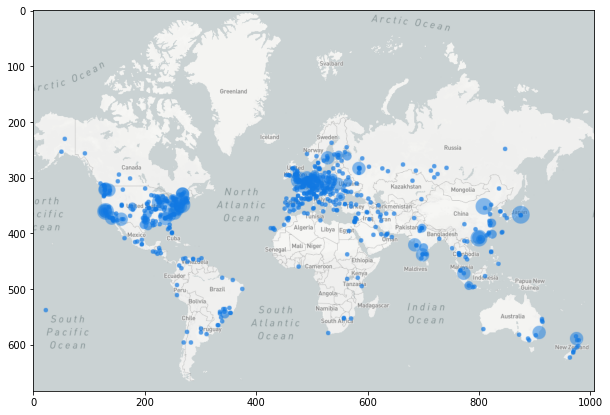

In [50]:
import matplotlib.image as mpimg
img = mpimg.imread('map.png')
plt.figure(figsize=(14,7))
plt.imshow(img)


In [59]:
bot_regex = 'Googlebot|AskJeeves|Digger|Lycos|msnbot|Inktomi Slurp|Yahoo|Nutch|bingbot|BingPreview|Mediapartners-Google|proximic|AhrefsBot|AdsBot-Google|Ezooms|AddThis.com|facebookexternalhit|MetaURI|Feedfetcher-Google|PaperLiBot|TweetmemeBot|Sogou web spider|GoogleProducer|RockmeltEmbedder|ShareThisFetcher|YandexBot|rogerbot-crawler|ShowyouBot|Baiduspider|Sosospider|Exabot|bot|crawler'


data = (apache_logs.map(lambda x: re.search(bot_regex,x)) 
    .filter(lambda x: x is not None)
    .count()
)




print(f"Movement generated by bots={data/apache_logs.count()*100}%")



Movement generated by bots=17.82%
